# Processing and narrating a video with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [4]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])


## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [6]:
video = cv2.VideoCapture("examples/data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")


618 frames read.


Display frames to make sure we've read them in correctly:


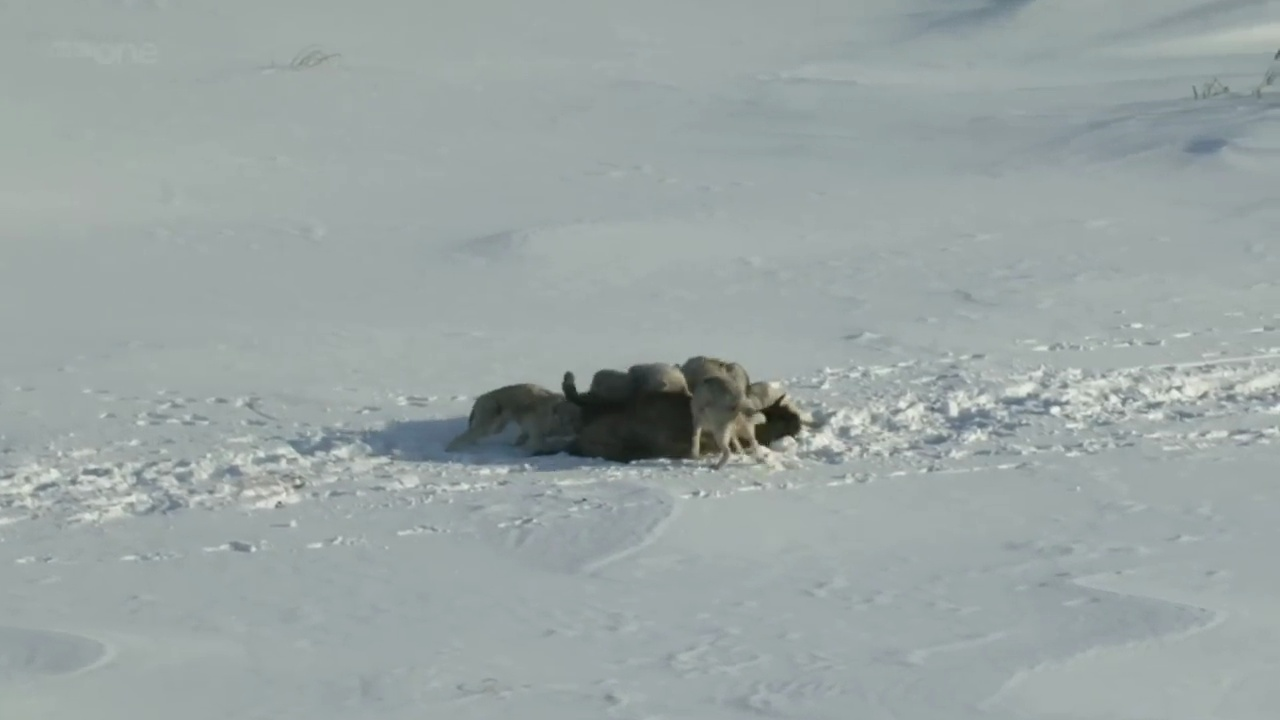

In [7]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)


Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [9]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            { "type": "text", "text": "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video." },
            *map(lambda x: { "type": "image_url", "image_url": { "url": f"data:image/jpeg;base64,{x}" }}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)


"Experience the raw power of nature as this gripping video unveils the dramatic confrontation between a determined pack of wolves and a resilient bison in a snow-covered landscape. Witness as the wolves, symbols of tenacity and teamwork, strategically coordinate their attack, and observe the bison's formidable defense in the face of relentless pursuit. This intense struggle for survival showcases the instinctual tactics employed by both predator and prey in the wild. The stark white of the snow serves as the ultimate backdrop for this life-and-death chase, a testament to the unforgiving and majestic beauty of nature's own theater. Tune in for a heart-pounding journey into the wild – where every moment is a battle for existence."

Note: When creating descriptions for nature videos involving predation or survival, it is essential to maintain a respectful and objective tone, recognizing the natural behaviors and ecological roles of the animals involved.


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [10]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: { "type": "image_url", "image_url": { "url": f"data:image/jpeg;base64,{x}" }}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)


In the unforgiving icy expanse, the drama of life plays out with stark intensity. A pack of wolves has isolated a bison from the herd, their coordinated strategy a dance of life and death. The bison, a formidable adversary, stands its ground against the encircling predators. It is a battle of endurance and will.

As the bison weaves and charges, attempting to fend off the relentless attackers, we witness the raw power and survival instincts that define the wild. This, a testament to the unyielding struggle that unfolds daily in these harsh, winter-clad lands.

One by one, the wolves test their adversary, looking for a weakness, but the bison, resilient in its strength, endures. The wolves are patient, their hunger driving their determination, while the bison, undeterred, continues to defy the odds. In these moments, nature reveals its most profound lessons — the harsh realities of the wild, where only the strongest and most cunning prevail.

But as the sun travels its low arc across th

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [12]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)


In [24]:
email_message = """
"""

In [31]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": 
            "Extract the text from the email below in a format suitable for a text to speech narration.\n" +
            "Include email title.\n" +
            "Include name of sender.\n" +
            "Include domain of e-mail sender.\n" +
            "Inform if I'm a direct recipient or if I'm in CC.\n" +
            "Inform if other people are included in the email.\n" +
            "Do not translate. If the email message is in portuguese, the entire extraction should be portuguese, including labels, if I'm direct recipient, etc..\n" +
            "Do not include email footer.\n" +
            "Do not include links.\n" +
            f"{email_message[:min(16384,len(email_message))]}"
    },
]
params = {
    "model": "gpt-3.5-turbo-1106",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 4096,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

Título do e-mail: Resolvido: Grupo MAP - Configuração da integração para rede privada [Graziella dos Imóveis]
Remetente: "Helpdesk da Órulo" <helpdesk@orulo.com.br>
Domínio do remetente: orulo.com.br
Para: "giovannavilasboas@grazielladosimoveis.com.br" <giovannavilasboas@grazielladosimoveis.com.br>, "graziella@grazielladosimoveis.com.br" <graziella@grazielladosimoveis.com.br>
Cc: Alejandro Olchik <alejandro@orulo.com.br>, Felipe Goettems <felipe@orulo.com.br>, "Órulo - Integração" <integracao@orulo.com.br>

Olá, Graziella Labate, Giovanna Vilas Boas.
O ticket Nº 40842 (Grupo MAP - Configuração da integração para rede privada [Graziella dos Imóveis]) foi considerado como resolvido pelo agente.
Você concorda que seu ticket foi resolvido?

ATENÇÃO: SOMENTE RESPONDA ESTE E-MAIL SE VOCÊ NÃO ESTIVER DE ACORDO COM A SOLUÇÃO APRESENTADA, POIS O TICKET SERÁ REABERTO COM A SUA RESPOSTA.

Fernando Florêncio
07/12/2023 13:39 (UTC-03:00 Horário de Brasília (Recife))



## Challenges to process e-mail:
Maximum token output of 4090

## Scope
- Chunking email extraction
- Summarization of email (avoid reading no useful content)

In [32]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)
